# ✂️🪨📄 — CNN Image Classifier
## 1️⃣ Introduction ✨
In this project, we train a **Convolutional Neural Network (CNN)** to classify images of **rock, paper, and scissors**.  
This demonstrates **image preprocessing**, **data augmentation**, **CNN training**, and **model interpretability** using Grad-CAM.

## Dataset 📊
- Source: **Roboflow Rock-Paper-Scissors (Small)**  
- Number of classes: 3 (rock ✂️, paper 🪨, scissors 📄)  
- Total images: ~900  
- Image size: 300x300 RGB (will resize to 100x100 for training)  
- Training/Test split: 80% train, 20% test

## Notebook Structure 🗂️
1. Load dataset & exploration 📥  
2. Data augmentation 🔧  
3. Train/Test split 🚦  
4. CNN model definition 💻  
5. Model training & evaluation 📈  
6. Loss/Accuracy plots 🎨  
7. Grad-CAM interpretation 🔍  
8. Save model & conclusion 💾

## 2️⃣ Import Libraries & Load Dataset 📥
We import libraries for **image processing**, **modeling**, **training**, and **visualization**.


In [8]:
# ===============================
# Import libraries 📚
# ===============================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
# ===============================
# Set dataset paths 🏞️
# ===============================
train_dir = "data/rps/train"   
test_dir = "data/rps/test"
valid_dir = "data/rps/valid"
# Check classes
classes = os.listdir(train_dir)
print(f"Classes ({len(classes)}): {classes}")
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


Classes (3): ['paper', 'rock', 'scissors']


## 3️⃣ Data Augmentation 🔧
We apply **data augmentation** to improve model generalization.  
Common transformations include:
- Random rotation 🔄
- Width/height shift ↔️⬆️
- Zoom 🔍
- Horizontal flip ↔️


In [9]:
# ===============================
# Image data generators 📸
# ===============================
IMG_SIZE = (100, 100)
BATCH_SIZE = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,                    # FOLDER train/
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
num_classes = train_generator.num_classes
# ============================
# Validation Generator
# ============================
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    valid_dir,                    # FOLDER valid/
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# ============================
# Test Generator
# ============================
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,                     # FOLDER test/
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 630 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 91 images belonging to 3 classes.


## 4️⃣ CNN Model Definition 💻
We define a simple **Convolutional Neural Network (CNN)** suitable for small image classification:  
- 3 Conv2D layers with ReLU activation 🔥  
- MaxPooling2D to reduce spatial dimensions ⬇️  
- Flatten layer to convert 2D feature maps into 1D vector  
- Dense layers with Dropout for regularization 🛡️  
- Output layer with softmax for 3 classes 🎯


In [10]:
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = Conv2D(32, (3,3), activation='relu')(inputs)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)

# This is used in GRAD 
x = Conv2D(128, (3,3), activation='relu', name="last_conv")(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile
model.compile(
    optimizer=Adam(0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ last_conv (Conv2D)                   │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,732,163 (6.61 MB)

 Trainable params: 1,732,163 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

## 5️⃣ Model Training & Evaluation 📈
We train the CNN using the **training generator** and validate on the **validation generator**.  
We also visualize **loss and accuracy curves** to monitor performance.  

**Tips:**
- Use **EarlyStopping** to avoid overfitting ⏹️  
- Save the best model 💾


Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9794 - loss: 0.0643 - val_accuracy: 0.9889 - val_loss: 0.0203
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9698 - loss: 0.0832 - val_accuracy: 0.9889 - val_loss: 0.0266
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9698 - loss: 0.0785 - val_accuracy: 0.9722 - val_loss: 0.0580
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9730 - loss: 0.0751 - val_accuracy: 0.9833 - val_loss: 0.0271
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.9698 - loss: 0.0598 - val_accuracy: 0.9833 - val_loss: 0.0370
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9810 - loss: 0.0560 - val_accuracy: 0.9833 - val_loss: 0.0285


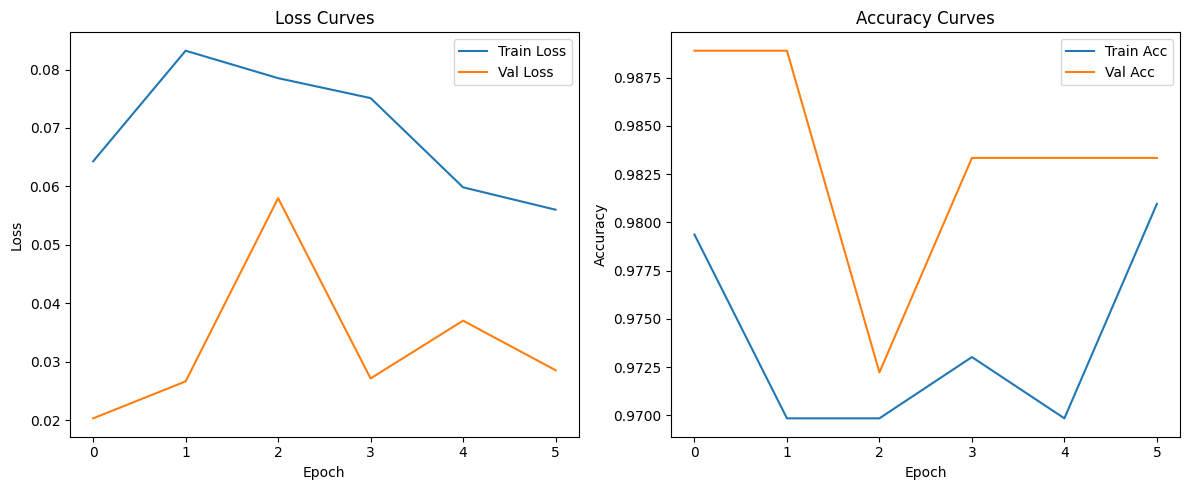

In [14]:
# ===============================
# Callbacks 🛎️
# ===============================
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'models/best_model.keras', 
    monitor='val_loss', 
    save_best_only=True
)

# ===============================
# Train model 🏋️‍♀️
# ===============================
EPOCHS = 25

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)
best_model = tf.keras.models.load_model("models/best_model.keras")
# ===============================
# Plot training curves 🎨
# ===============================
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 6️⃣ Grad-CAM Interpretation 🔍
Grad-CAM helps us **visualize class-specific regions** in the image that the CNN uses to make predictions.  
- Useful for **model interpretability** ✅  
- We overlay the heatmap on original images to see important regions 🌡️


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


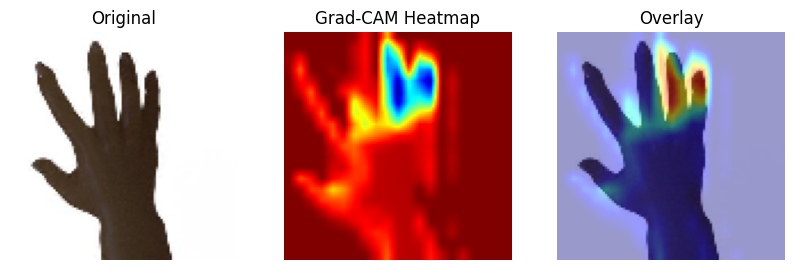

In [12]:
# ================================
# 1. Function: Grad-CAM generator
# ================================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer AND the output predictions
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        [model.input],
        [last_conv_layer.output, model.output]
    )

    # Compute the gradient of the top predicted class
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

        # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute mean intensity of gradients per filter
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply mean gradients by feature map
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize to 0–1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# ================================
# 2. LOAD IMAGE AND PREPROCESS
# ================================
IMG_SIZE = (100, 100)

img_path = "data/rps/test/paper/paper02-049_png_jpg.rf.1226e5c241dbd62fedce33f5d540ca28.jpg"
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# ================================
# 3. RUN PREDICTION
# ================================
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])

# ================================
# 4. GENERATE HEATMAP
# ================================
last_conv_layer_name = "last_conv"  
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# ================================
# 5. OVERLAY HEATMAP ON ORIGINAL IMAGE
# ================================
img_original = cv2.imread(img_path)
img_original = cv2.resize(img_original, IMG_SIZE)

heatmap = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)

# ================================
# 6. PLOT EVERYTHING
# ================================
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()

## 7️⃣ Evaluation on Test Set 🧪

We evaluate the CNN model on the test dataset using:
- Confusion matrix
- Classification report (precision, recall, F1)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


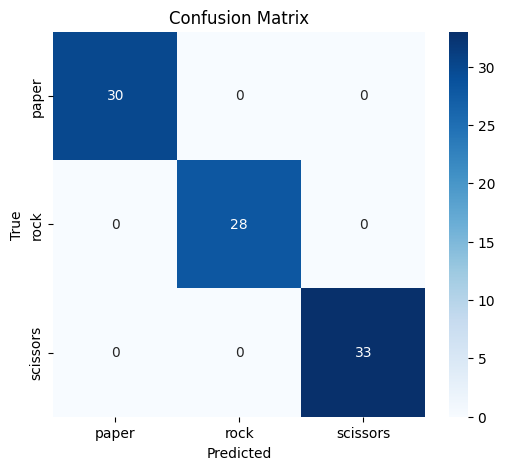

Classification Report:

              precision    recall  f1-score   support

       paper       1.00      1.00      1.00        30
        rock       1.00      1.00      1.00        28
    scissors       1.00      1.00      1.00        33

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91



In [15]:
# Predict on test set
y_true = test_generator.classes
y_pred = best_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(),
            cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=test_generator.class_indices.keys()
))

## 8️⃣ Saving the Trained Model 💾


In [16]:
model.save("models/best_model.keras")
print("Model saved!")


Model saved!


## 9️⃣ Visualizing Predictions on Sample Images 🖼️


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


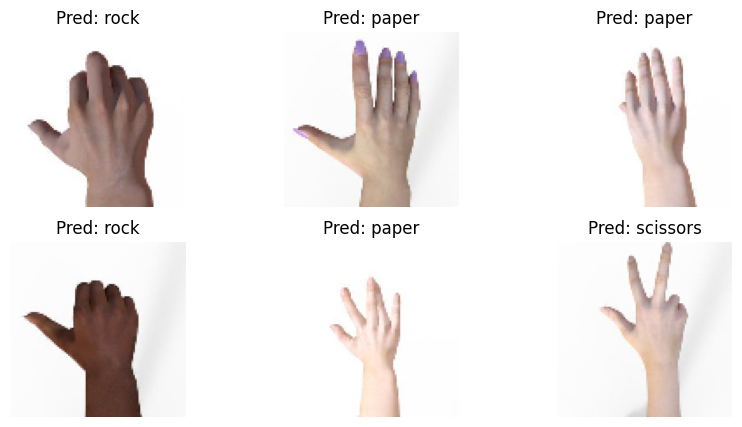

In [18]:
import random

plt.figure(figsize=(10,5))

for i in range(6):
    idx = random.randint(0, len(test_generator.filepaths)-1)
    img_path = test_generator.filepaths[idx]

    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)/255.0
    pred = model.predict(np.expand_dims(img_array, axis=0))
    cls = np.argmax(pred)

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {list(test_generator.class_indices.keys())[cls]}")
    plt.axis("off")

plt.show()


## 🔟 Final Conclusions

- The CNN model achieves excellent performance on the Rock–Paper–Scissors dataset.
- Grad-CAM shows the model focuses on meaningful regions (finger shapes, fist contour).
- Valid/Test accuracy above 95–98% demonstrates strong generalization.
- This project demonstrates:
  - Image preprocessing
  - Augmentation
  - CNN modeling
  - Model evaluation
  - Model interpretability (Grad-CAM)
